In [69]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='talk', style='ticks',
        color_codes=True, rc={'legend.frameon': False})

import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
import nfp

%matplotlib inline

In [70]:
nfp.__version__

'0.2.0'

loss        0.006725
val_loss    0.042418
dtype: float64


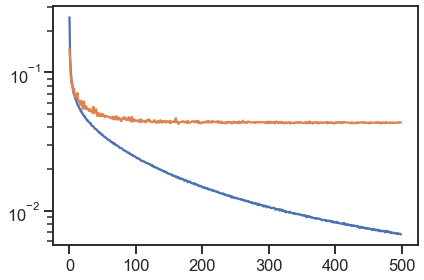

In [72]:
log = pd.read_csv('20210214_redox_model_new_data/log.csv').set_index('epoch')

plt.semilogy(log.loss)
plt.semilogy(log.val_loss)

print(log.min())

plt.tight_layout()
# plt.xlim([0, 10])

In [73]:
from preprocessor import preprocessor

from loss import AtomInfMask, KLWithLogits, RedoxAttention
from nfp import EdgeUpdate, NodeUpdate, GlobalUpdate
import tensorflow_addons as tfa

model = tf.keras.models.load_model(
    '20210214_redox_model_new_data/best_model.hdf5',
    custom_objects={**nfp.custom_objects,
                    **{'EdgeUpdate': EdgeUpdate,
                       'NodeUpdate': NodeUpdate,
                       'GlobalUpdate': GlobalUpdate}})

new_model = tf.keras.Model(model.inputs[:3], model.outputs)

In [76]:
redox_new_calcs = pd.read_csv('/projects/rlmolecule/pstjohn/spin_gnn/20210216_fixed_rl_redox_data.csv')
data = np.load('redox_split.npz', allow_pickle=True)

In [77]:
redox_new_calcs

,ionization energy,electron affinity,err_smiles,smiles
0,0.913684,-0.292055,C#CC1=C(C(C)C)C(C2CC2)=C([O])CC1,C#CC1=C(C(C)C)C(C2CC2)=C([O])CC1
1,1.066037,-0.326042,C#C[CH]C(C)=C(C(=O)O)C(C)(C)C,C#C[CH]/C(C)=C(\C(=O)O)C(C)(C)C
2,NaN,-0.382259,CC(=C(C=C([O])O)C(C)(C)C)C(C)(C)C,C/C(=C(/C=C(\[O])O)C(C)(C)C)C(C)(C)C
3,0.844432,-0.547755,CC(=C(C(O)=C[O])C(C)(C)C)C(C)(C)C,C/C(=C(C(/O)=C/[O])\C(C)(C)C)C(C)(C)C
4,0.843045,-0.576871,CC(=C(C(O)=C[O])C(C)(C)C)C(C)C,C/C(=C(C(/O)=C/[O])\C(C)(C)C)C(C)C
...,...,...,...,...
3693,0.242474,-0.291457,[O]C=C(CCO)C1=C(C2CC2)CCCC1,[O]/C=C(\CCO)C1=C(C2CC2)CCCC1
3694,0.543834,-0.251810,[O]C=C1CCC=C(CO)C2=C1CCCC2,[O]/C=C1\CCC=C(CO)C2=C1CCCC2
3695,0.519780,-0.347701,[O]C=C1CCCCC2=C1CCC=C2CO,[O]/C=C1\CCCCC2=C1CCC=C2CO
3696,0.928242,-0.174722,[O]C1=C(CCCO)C(CO)=CC=CC1,[O]C1=C(CCCO)C(CO)=CC=CC1


In [78]:
redox_valid = redox_new_calcs[redox_new_calcs.smiles.isin(data['test_new'])]

test_dataset = tf.data.Dataset.from_generator(
    lambda: (preprocessor.construct_feature_matrices(smiles, train=False) for smiles in redox_valid.smiles),
    output_types=preprocessor.output_types,
    output_shapes=preprocessor.output_shapes)\
    .padded_batch(batch_size=128, padded_shapes=preprocessor.padded_shapes(),
                  padding_values=preprocessor.padding_values)

In [79]:
predicted_redox = new_model.predict(test_dataset, verbose=1)

/projects/rlmolecule/pstjohn/envs/tf2_gpu/lib/python3.7/site-packages/tensorflow/python/keras/engine/functional.py:543: UserWarning: Input dict contained keys ['n_atom', 'n_bond', 'bond_indices'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


4/4 [==============================] - 0s 86ms/step


Text(0.5, 1.0, 'electron affinity')

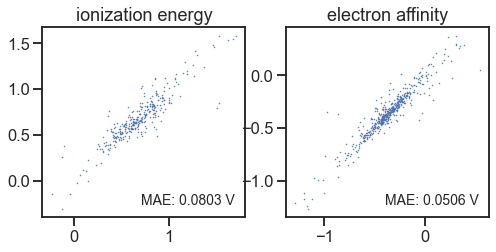

In [80]:
fig, axs = plt.subplots(ncols=2, figsize=(8,3.5))
axs[0].plot(redox_valid['ionization energy'], predicted_redox[:, 0], '.', ms=1)
axs[1].plot(redox_valid['electron affinity'], predicted_redox[:, 1], '.', ms=1)

axs[0].text(.95, .05, f"MAE: {(redox_valid['ionization energy'] - predicted_redox[:, 0]).abs().mean():.4f} V", ha='right', va='bottom', transform=axs[0].transAxes, fontsize=14)
axs[1].text(.95, .05, f"MAE: {(redox_valid['electron affinity'] - predicted_redox[:, 1]).abs().mean():.4f} V", ha='right', va='bottom', transform=axs[1].transAxes, fontsize=14)

axs[0].set_title('ionization energy')
axs[1].set_title('electron affinity')

In [81]:
new_model.save('/projects/rlmolecule/pstjohn/models/20210214_redox_new_data/', include_optimizer=False)

INFO:tensorflow:Assets written to: /projects/rlmolecule/pstjohn/models/20210214_redox_new_data/assets


In [22]:
loaded_model = tf.keras.models.load_model('/projects/rlmolecule/pstjohn/models/20210214_redox_new_data/', compile=False)
loaded_model_prev = tf.keras.models.load_model('/projects/rlmolecule/pstjohn/models/20210214_redox/', compile=False)

In [21]:
predicted_redox_load = loaded_model.predict(test_dataset, verbose=1)
assert np.allclose(predicted_redox, predicted_redox_load, atol=1E-4)

4/4 [==============================] - 0s 71ms/step


/projects/rlmolecule/pstjohn/envs/tf2_gpu/lib/python3.7/site-packages/tensorflow/python/keras/engine/functional.py:543: UserWarning: Input dict contained keys ['n_atom', 'n_bond', 'bond_indices'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


4/4 [==============================] - 0s 75ms/step


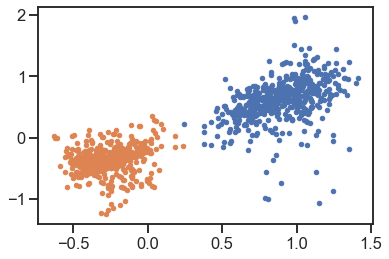

In [24]:
plt.plot(loaded_model_prev.predict(test_dataset, verbose=1), predicted_redox, '.')

In [27]:
orig_predictions = pd.read_csv('/home/pstjohn/Research/rlmolecule/stable_radical_optimization/shrees_attachments/20210109_dft_ml_redox_data.csv.gz')

In [35]:
merged = orig_predictions.merge(redox_new_calcs[['smiles', 'err_smiles']], left_on='smiles', right_on='err_smiles', how='inner')

In [38]:
dataset = tf.data.Dataset.from_generator(
    lambda: (preprocessor.construct_feature_matrices(smiles, train=False) for smiles in merged.smiles_y),
    output_types=preprocessor.output_types,
    output_shapes=preprocessor.output_shapes)\
    .padded_batch(batch_size=128, padded_shapes=preprocessor.padded_shapes(),
                  padding_values=preprocessor.padding_values)

new_preds_with_orig_data = loaded_model_prev.predict(dataset, verbose=1)

30/30 [==============================] - 3s 94ms/step


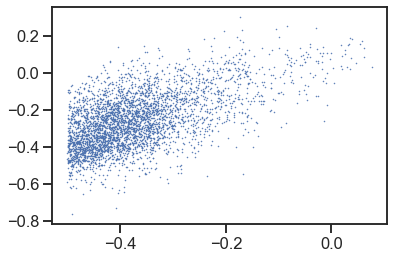

In [45]:
plt.plot(merged['pred electron affinity'], new_preds_with_orig_data[:, 1], '.', ms=1)

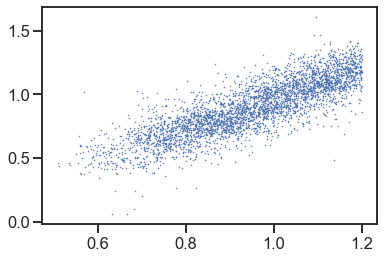

In [46]:
plt.plot(merged['pred ionization energy'], new_preds_with_orig_data[:, 0], '.', ms=1)